# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2019-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 1 is due February 6th

In [75]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [76]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [77]:
#your code here
calendar_train = pd.read_csv("data/calendar_train.csv", parse_dates=["date"])
calendar_test = pd.read_csv("data/calendar_test.csv", parse_dates=["date"])

The `price` field is empty in many cases

In [78]:
display(calendar_test.isna().sum())
display(calendar_train.isna().sum())

listing_id         0
date               0
available          0
price         181472
dtype: int64

listing_id         0
date               0
available          0
price         424715
dtype: int64

We have many, many rows. So let's just drop the NaNs

In [79]:
calendar_test.dropna(inplace=True)
calendar_train.dropna(inplace=True)

In [80]:
calendar_train.head()

,listing_id,date,available,price
123,20872145,2018-04-02,t,62.0
124,20872145,2018-04-01,t,59.0
125,20872145,2018-03-31,t,75.0
126,20872145,2018-03-30,t,71.0
127,20872145,2018-03-28,t,51.0


In [81]:
calendar_train.describe()

,listing_id,price
count,3.092880e+05,309288.000000
mean,1.185732e+07,238.780612
std,6.716094e+06,188.527983
min,3.781000e+03,15.000000
25%,5.940866e+06,115.000000
50%,1.302981e+07,190.000000
75%,1.815527e+07,299.000000
max,2.122836e+07,5993.000000


### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

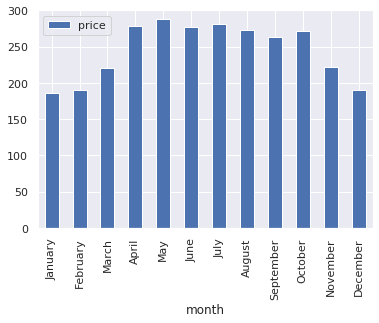

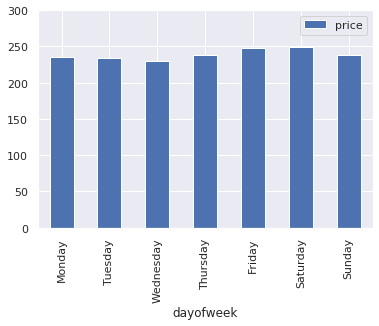

In [82]:
#your code here
calendar_train['month'] = calendar_train['date'].dt.month_name()
calendar_train[['price','month']].groupby("month").\
mean().reset_index().reindex([4,3,7,0,8,6,5,1,11,10,9,2]).set_index('month').plot.bar(ylim=[0,300]);

calendar_train['dayofweek'] = calendar_train['date'].apply(lambda x : x.strftime('%A'))

calendar_train[['price','dayofweek']].groupby("dayofweek").\
mean().reset_index().reindex([1,5,6,4,0,2,3]).set_index('dayofweek').plot.bar(ylim=[0,300]);

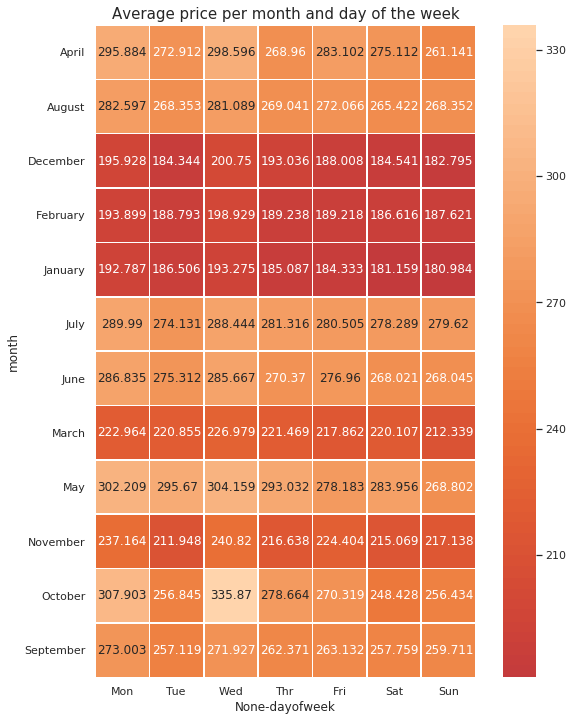

In [83]:
# Interesting plot drawn from a student submission

#Add a table showing the average price per day and month
avg_month_day = calendar_train.groupby(['month','dayofweek']).agg({'price':'mean'})
avg_month_day = avg_month_day.unstack()

#Create graph for average prices
import seaborn as sns
sns.set(rc={'figure.figsize':(10,12)})
plt.title('Average price per month and day of the week', size=15)
# Labeling days is preferred because it's not always clear whether 0 is Monday, as in this case, or Sunday
sns.heatmap(avg_month_day, center=0,
            square=True, linewidths=.5, annot=True , fmt='g',
            xticklabels=["Mon", "Tue", "Wed", "Thr", "Fri", "Sat", "Sun"]);


**Take-aways**
Note trends like lower prices in winter months (this is Boston!), and higher prices on Fridays/Saturdays

Lower prices in winter months, potentially attributed to demand contraction as they are not traditional (average) vacation months.

Rental pattern per day decreases on average to a week min in Wednesday increasing towards end of the week. Consistent with rationale that people on average may try to time time-off closer to the weekend.**

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [84]:
calendar_train['days_since'] = (calendar_train['date'] - calendar_train['date'].min()).dt.days.astype(float)
calendar_test['days_since'] = (calendar_test['date'] - calendar_test['date'].min()).dt.days

In [85]:
train_agg = calendar_train[['price','days_since']].groupby("days_since", as_index=False).mean()
test_agg = calendar_train[['price','days_since']].groupby("days_since", as_index=False).mean()

### 1. Polynomials

In [86]:
x_pred = pd.DataFrame({'days_since': 1.0*np.arange(365)})

In [87]:
cal_lm2 = sm.ols(formula="price ~ np.vander(days_since, 3, increasing=True) -1", data=calendar_train).fit()
cal_lm3 = sm.ols(formula="price ~ np.vander(days_since, 4, increasing=True) -1", data=calendar_train).fit()
cal_lm5 = sm.ols(formula="price ~ np.vander(days_since, 6, increasing=True) -1", data=calendar_train).fit()
cal_lm8 = sm.ols(formula="price ~ np.vander(days_since, 9, increasing=True) -1", data=calendar_train).fit()

Degree 2
R^2 Train: 0.0185
R^2 Test:  0.0192


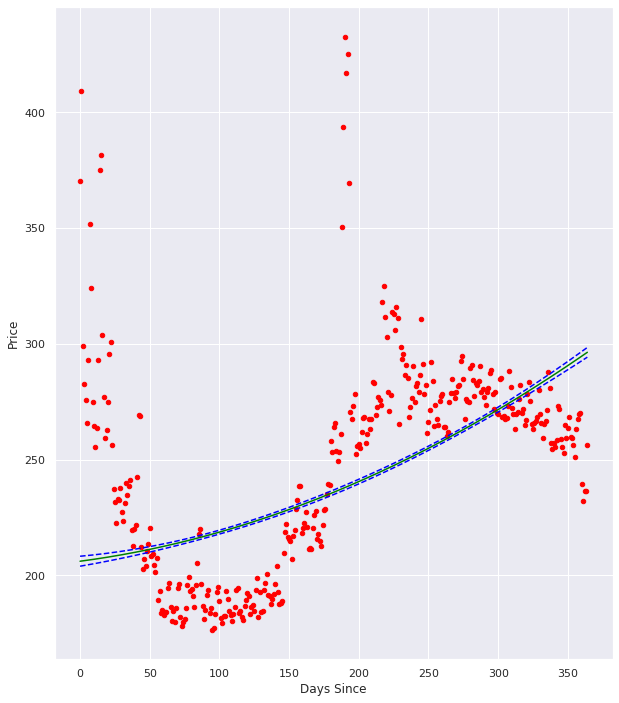

Degree 3
R^2 Train: 0.0389
R^2 Test:  0.0388


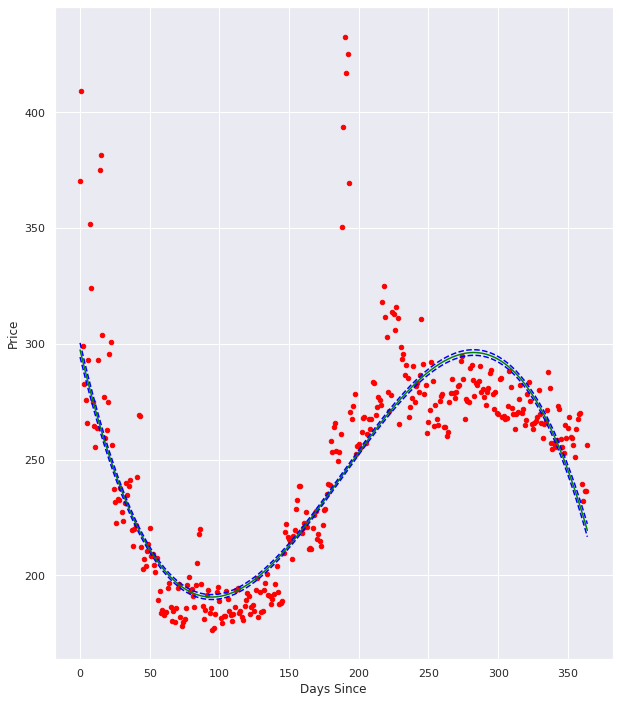

Degree 5
R^2 Train: 0.0421
R^2 Test:  0.0417


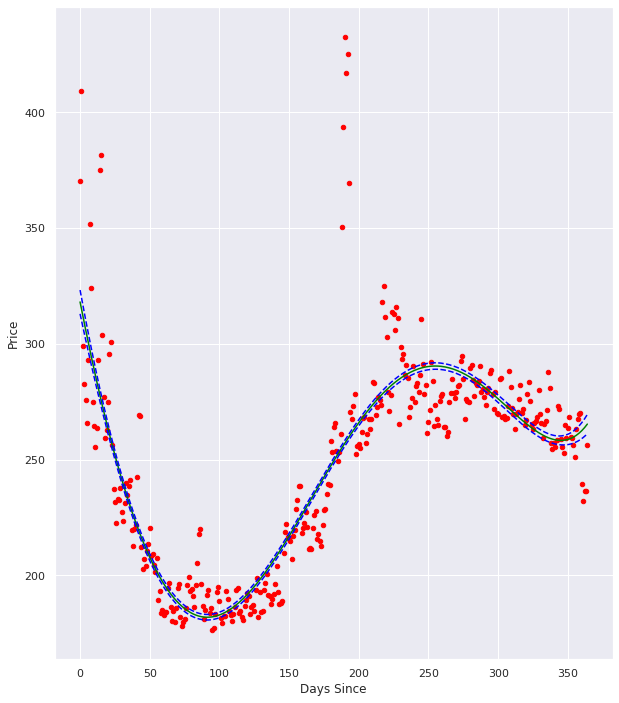

Degree 8
R^2 Train: -0.2377
R^2 Test:  -118496.4300


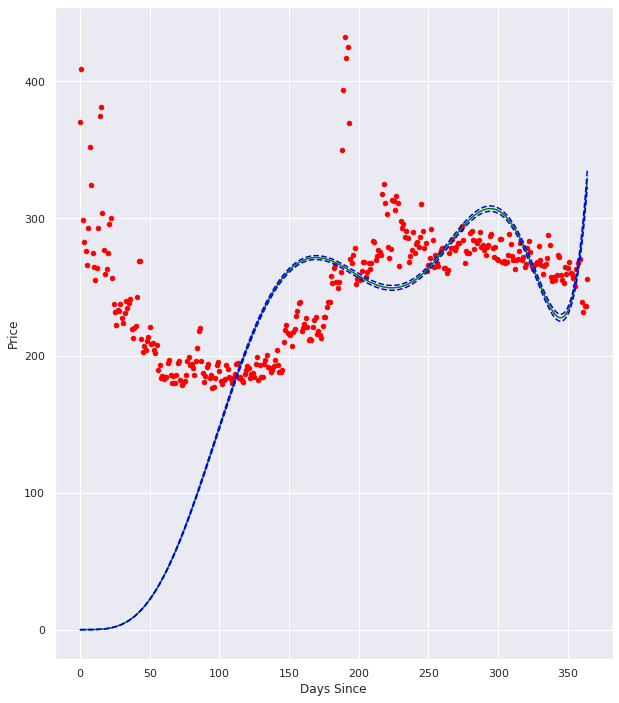

In [88]:
models = [cal_lm2, cal_lm3, cal_lm5, cal_lm8]
labels = ["Degree 2", "Degree 3", "Degree 5", "Degree 8"]

for model, label in zip(models, labels):
    plot_predictions = model.get_prediction(x_pred).summary_frame()
    train_predictions = model.get_prediction(calendar_train).summary_frame()
    test_predictions = model.get_prediction(calendar_test).summary_frame()
    
    print(label)
    print("R^2 Train: {:0.4f}".format(r2_score(calendar_train['price'], train_predictions['mean'])))
    print("R^2 Test:  {:0.4f}".format(r2_score(calendar_test['price'], test_predictions['mean'])))
    
    ax1 = train_agg.plot.scatter(x='days_since', y='price', c='red')
    ax1.set_xlabel("Days Since")
    ax1.set_ylabel("Price")

    ax1.plot(x_pred['days_since'], plot_predictions['mean'],color="green")

    # CI for the predection at each x value, i.e. the line itself
    ax1.plot(x_pred['days_since'], plot_predictions['mean_ci_lower'], color="blue",linestyle="dashed")
    ax1.plot(x_pred['days_since'], plot_predictions['mean_ci_upper'], color="blue",linestyle="dashed");

    # CIs for where future data will fall
    #ax1.plot(xpred.age, prediction_output['obs_ci_lower'], color="skyblue",linestyle="dashed")
    #ax1.plot(xpred.age, prediction_output['obs_ci_upper'], color="skyblue",linestyle="dashed");
    
    plt.show()

It appears that as the order of the polynomial increases, the R^2 value increases as well, though no model did exceptionally well. (Not that we would expect large R^2 -- there are a wide range of prices on a given day and any model predicting a single price for that day would pay a large squared-error penalty.)

### 2. Degree 8 oddity
The coefficients are going nutty because of numerical instability, resulting in floating point errors in the predictions. The fixes are a) scaling the data to a smaller range (a band-aid) and b) using orthogonal polynomials instead of raw polynomials. The latter will de-correlate the columns in the design matrix and thus produce far more stable outputs.

### A brief aside about `statsmodels` implementation of OLS for the perplexed

To find the parameters of our OLS model we need to solve the normal equation which [Wikipedia](https://en.wikipedia.org/wiki/Numerical_methods_for_linear_least_squares#Inverting_the_matrix_of_the_normal_equations) would have you believe looks like this:

$\hat{\beta} = (X^\top X)^{-1}X^\top y = X^{+}y$

Where $X^+$ is the [Moore-Penrose pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse).  

Let's try both methods of calculating $\hat{\beta}$

In [141]:
from numpy.linalg import pinv, inv

X = np.vander(calendar_train.days_since, 9, increasing=True)
y = calendar_train.price
betas = {}
betas['inv'] = inv(X.T @ X) @ X.T @ y 
betas['pinv'] = pinv(X) @ y

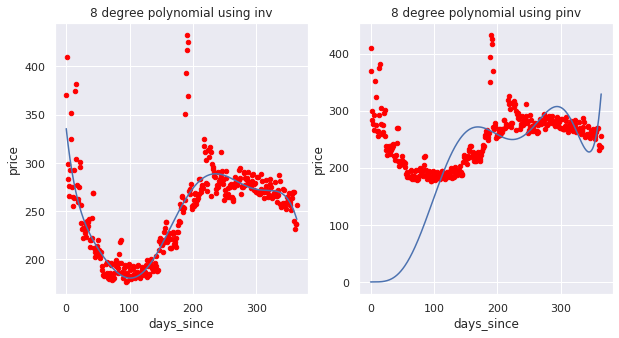

In [143]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
def plot_it(betas, ax, method):
    X_eval = np.vander(np.arange(365.0), 9, increasing=True)
    preds = betas@X_eval.T
    train_agg.plot.scatter(x='days_since', y='price', c='red', ax=ax);
    ax.plot(preds)
    ax.set_title(f'8 degree polynomial using {method}')    
for ax, (method, b) in zip(axes, betas.items()):
    plot_it(b, ax, method)

Calculating the pseudo inverse relys on [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) and it is here that the numerical instability appears to creep in.  
Let's see what `statsmodels` is doing when we fit our OLS model:

In [160]:
doc = sm.ols(formula="price ~ np.vander(days_since, 9, increasing=True) -1", data=calendar_train).fit.__doc__
print(doc[:397]+'\t...\n'*3+doc[-165:])


        Full fit of the model.

        The results include an estimate of covariance matrix, (whitened)
        residuals and an estimate of scale.

        Parameters
        ----------
        method : str, optional
            Can be "pinv", "qr".  "pinv" uses the Moore-Penrose pseudoinverse
            to solve the least squares problem. "qr" uses the QR
            factorization.
       	...
	...
	...
        Notes
        -----
        The fit method uses the pseudoinverse of the design/exogenous variables
        to solve the least squares minimization.
        


Well, there is our problem! Using [QR factorization](https://en.wikipedia.org/wiki/QR_decomposition) we end up with a reasonable looking result.

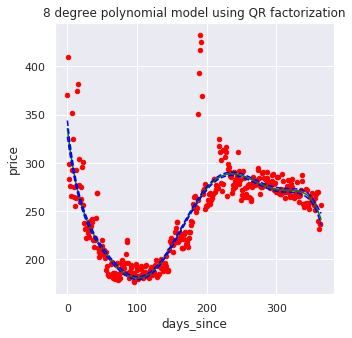

In [144]:
cal_lm8_qr = sm.ols(formula="price ~ np.vander(days_since, 9, increasing=True) -1", data=calendar_train).fit(method='qr')
plot_predictions = cal_lm8_qr.get_prediction(x_pred).summary_frame()

fig, ax = plt.subplots(figsize=(5,5))

train_agg.plot.scatter(x='days_since', y='price', c='red', ax=ax);
ax.plot(x_pred['days_since'], plot_predictions['mean'],color="green")
ax.plot(x_pred['days_since'], plot_predictions['mean_ci_lower'], color="blue",linestyle="dashed")
ax.plot(x_pred['days_since'], plot_predictions['mean_ci_upper'], color="blue",linestyle="dashed")
ax.set_title('8 degree polynomial model using QR factorization');

Students were not expected to know these details about how OLS is implemented.

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

In [145]:
from pygam import LinearGAM, s, f

In [146]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

candidate_smoothings = [0, .01, .1, 1, 10, 100, 1000]

kf = KFold(n_splits=5, random_state=47, shuffle=True)
scores = np.zeros((5,len(candidate_smoothings)))

for i, (train_index, test_index) in enumerate(kf.split(calendar_train)):
    train_df = calendar_train.iloc[train_index,:]
    test_df = calendar_train.iloc[test_index,:]
    
    for j,cur_smoothing in enumerate(candidate_smoothings):
        cur_model_smooth = LinearGAM(s(0, lam=cur_smoothing)).fit(train_df['days_since'],train_df['price'])
        
        scores[i,j] = r2_score(test_df['price'], cur_model_smooth.predict(test_df['days_since']))
        
print("Average 5-fold CV R^2 scores:", np.mean(scores, axis=0))
# for i in range(len(candidate_smoothings)):
#     plt.scatter([i]*5, scores[:,i])

Average 5-fold CV R^2 scores: [0.04476701 0.04476709 0.04476783 0.04477167 0.04475163 0.04440697
 0.0438238 ]


Because the optimal lambda chosen by cross validation is very small to begin with (1) it's hard to see much difference between the optimal smoothing plot and one with less.

Best s:  1


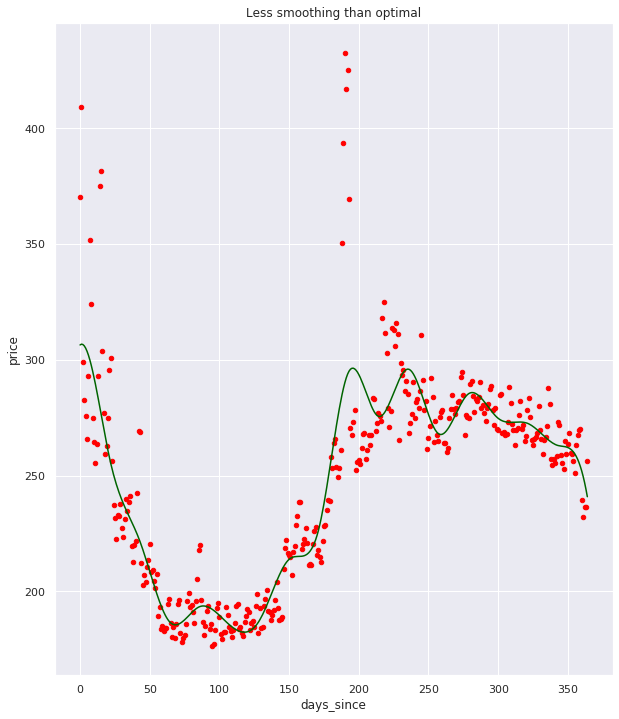

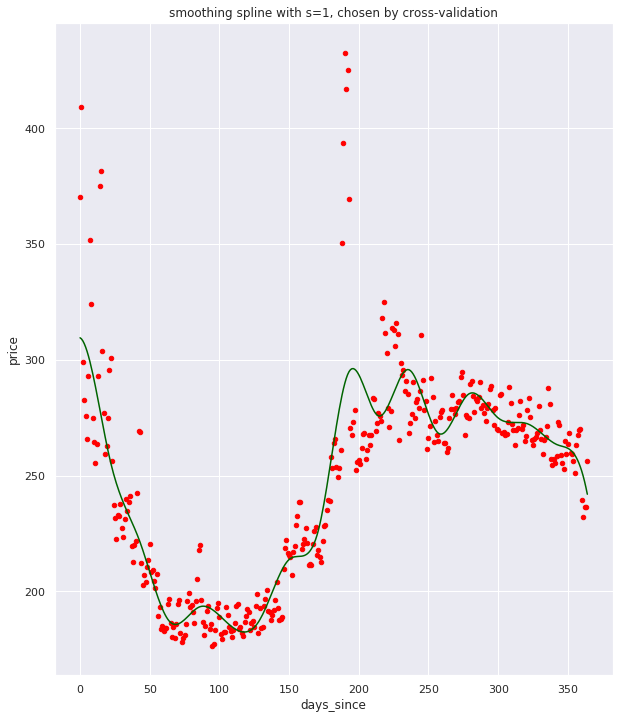

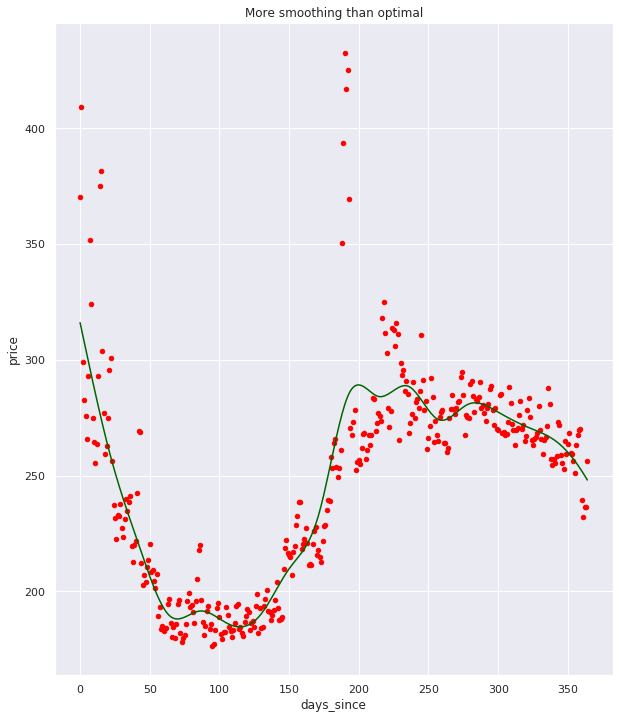

In [147]:
best_s = candidate_smoothings[np.argmax(np.mean(scores, axis=0))]
print("Best s: ", best_s)

ax = train_agg.plot.scatter(x='days_since',y='price',c='Red',title="Less smoothing than optimal")
best_model = LinearGAM(s(0, lam=0)).fit(calendar_train['days_since'],calendar_train['price'])
ax.plot(x_pred, best_model.predict(x_pred), color="darkgreen")
plt.show()

ax = train_agg.plot.scatter(x='days_since',y='price',c='Red',title="smoothing spline with s={}, chosen by cross-validation".format(best_s))
best_model = LinearGAM(s(0, lam=best_s)).fit(calendar_train['days_since'],calendar_train['price'])
ax.plot(x_pred, best_model.predict(x_pred), color="darkgreen")
plt.show()

ax = train_agg.plot.scatter(x='days_since',y='price',c='Red',title="More smoothing than optimal")
best_model = LinearGAM(s(0, lam=best_s*100)).fit(calendar_train['days_since'],calendar_train['price'])
ax.plot(x_pred, best_model.predict(x_pred), color="darkgreen")
plt.show()

In [148]:
train_score = r2_score(calendar_train['price'], best_model.predict(calendar_train['days_since']))
test_score = r2_score(calendar_test['price'], best_model.predict(calendar_test['days_since']))
print("Best model's R^2 scores: train {:0.4f}, test {:0.4f}".format(train_score, test_score))

Best model's R^2 scores: train 0.0446, test 0.0443


### 4. Effects of parameters
Increasing the 'degree' parameter pushes the polynomial models towards overfitting, while increasing the smoothing parameter pushes the spline models to underfitting. The one that performs best is the one with highest test $R^2$, in this case the smoothing spline with s = 1. 

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [149]:
calendar_train['weekend'] = 1*np.logical_or(calendar_train['date'].dt.weekday == 5, calendar_train['date'].dt.weekday == 6)
calendar_test['weekend'] = 1*np.logical_or(calendar_test['date'].dt.weekday == 5, calendar_test['date'].dt.weekday == 6)

pred_dates = calendar_train['date'].min() + pd.to_timedelta(x_pred['days_since'], unit='D')
x_pred_weekend = pd.DataFrame({"days_since": np.arange(0,365), "weekend": np.logical_or(pred_dates.dt.weekday ==5, pred_dates.dt.weekday ==6)})

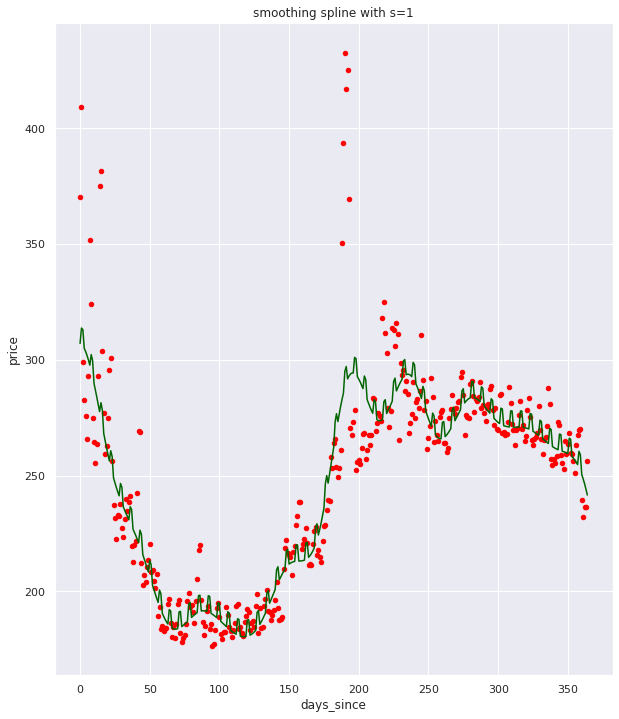

In [150]:
from pygam import f, l

# We have not necessarily chosen this s=1 from cross validation because perhaps different s is better with new weekend indicator
ax = train_agg.plot.scatter(x='days_since',y='price',c='Red',title="smoothing spline with s={}".format(best_s))
weekend_model = LinearGAM(s(0, lam=best_s) + l(1)).fit(calendar_train[['days_since', 'weekend']],  calendar_train['price'])
ax.plot(x_pred['days_since'], weekend_model.predict(x_pred_weekend), color="darkgreen")
plt.show()


In [151]:
train_score = r2_score(calendar_train['price'], weekend_model.predict(calendar_train[['days_since', 'weekend']]))
test_score = r2_score(calendar_test['price'], weekend_model.predict(calendar_test[['days_since', 'weekend']]))
print("Best model's R^2 scores: train {:0.4f}, test {:0.4f}".format(train_score, test_score))

Best model's R^2 scores: train 0.0452, test 0.0450


The model performance increases slightly, although it might also be fair to consider this as performing roughtly the same as without the weekend indicator if student discusses this and a fair preference for simpler models. Still, test $R^2$ increases.

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [152]:
calendar_train.groupby(['date'], as_index=False).agg({'price':'mean', 'weekend':'mean', 'listing_id':'count'}).sort_values('price').iloc[-10:,:]

,date,price,weekend,listing_id
7,2017-10-13,351.800725,0,276
193,2018-04-17,369.371060,0,698
0,2017-10-06,370.173410,0,173
14,2017-10-20,374.955932,0,295
15,2017-10-21,381.526515,1,264
189,2018-04-13,393.609047,0,619
1,2017-10-07,409.298701,1,154
191,2018-04-15,417.170404,1,446
192,2018-04-16,425.289528,0,487
190,2018-04-14,432.680761,1,473


The highest-priced dates tend to have particularly low value counts- it's likely that these days have unusually high prices because they happened to sample a high-priced listing. However, Marathon Monday (4/16) and nearby days are also included, and could realistically be expected to command high prices. 

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [153]:
#your code here
listings_train = pd.read_csv("data/listings_train.csv")
listings_test = pd.read_csv("data/listings_test.csv")

In [154]:
listings_train.head()

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,Private room,42.347956,-71.155196,1.0,1,1,52,1,65,365,26
1,85,Entire home/apt,42.349299,-71.083470,1.0,0,1,110,1,104,107,38
2,6,Entire home/apt,42.341902,-71.073792,1.0,1,1,67,45,56,322,9
3,1,Entire home/apt,42.319235,-71.105016,2.0,2,2,103,8,113,341,49
4,1,Entire home/apt,42.346452,-71.134896,1.0,0,1,8,24,82,41,13


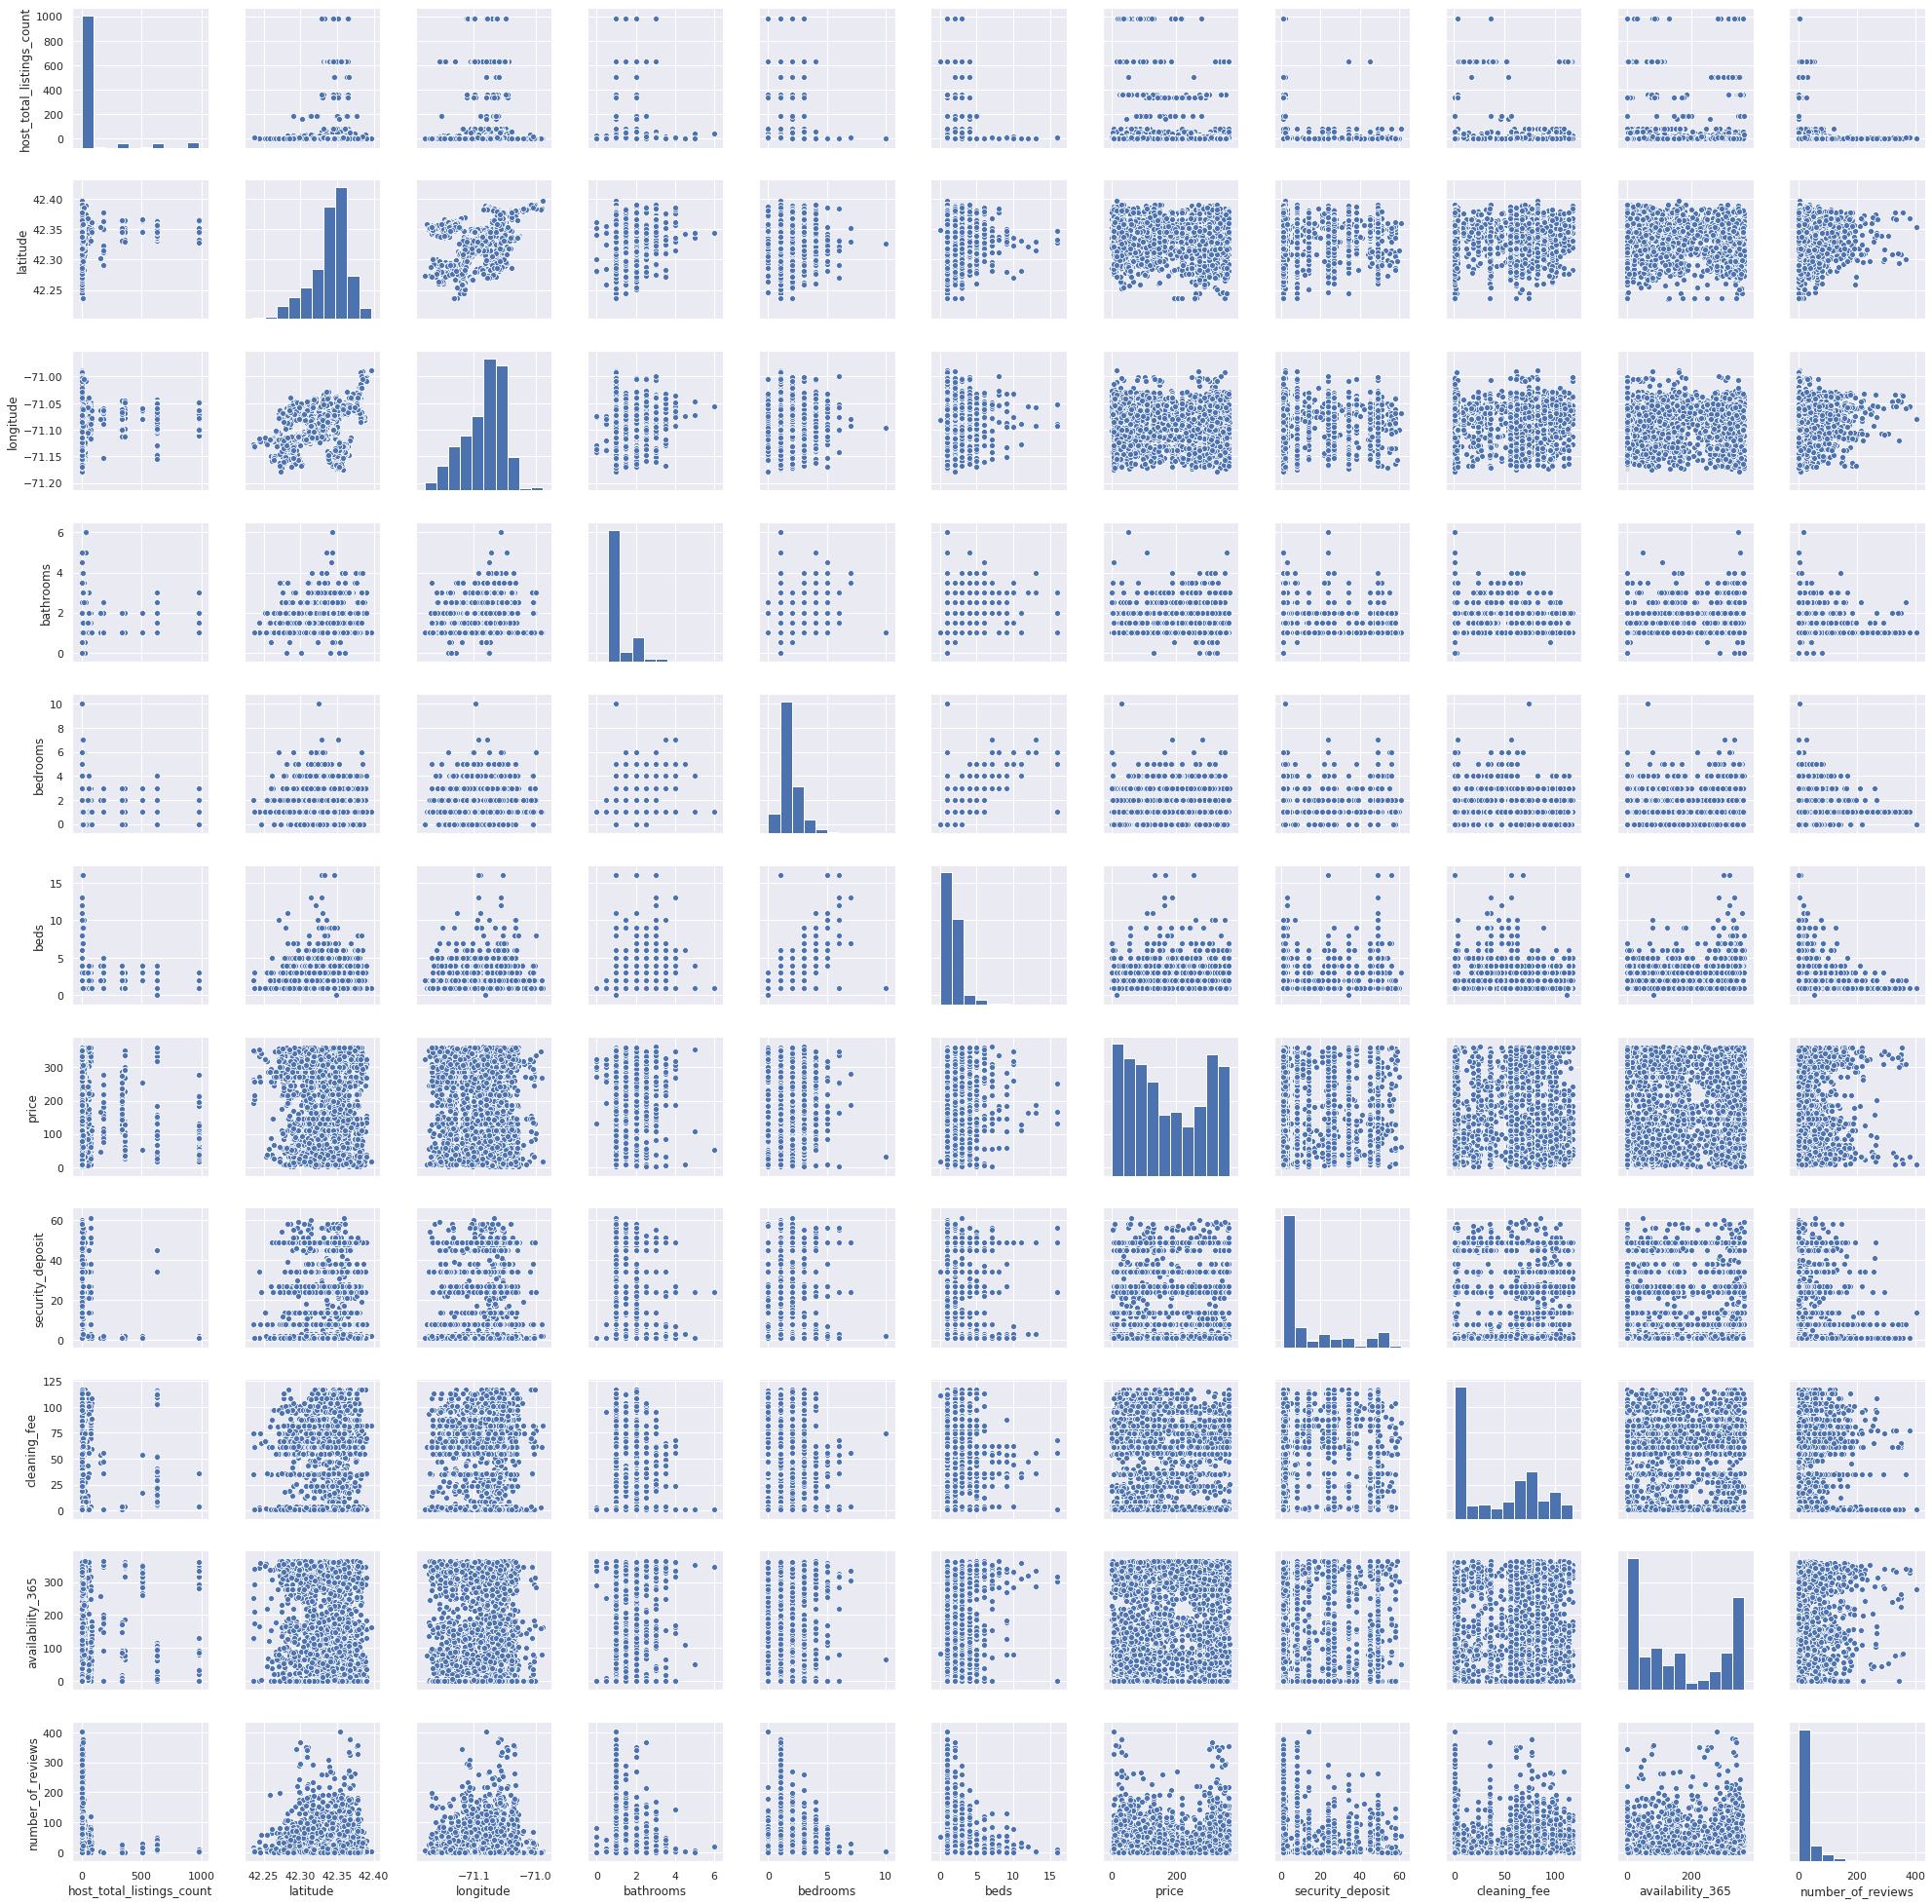

In [155]:
# Create the default pairplot
sns.pairplot(listings_train);

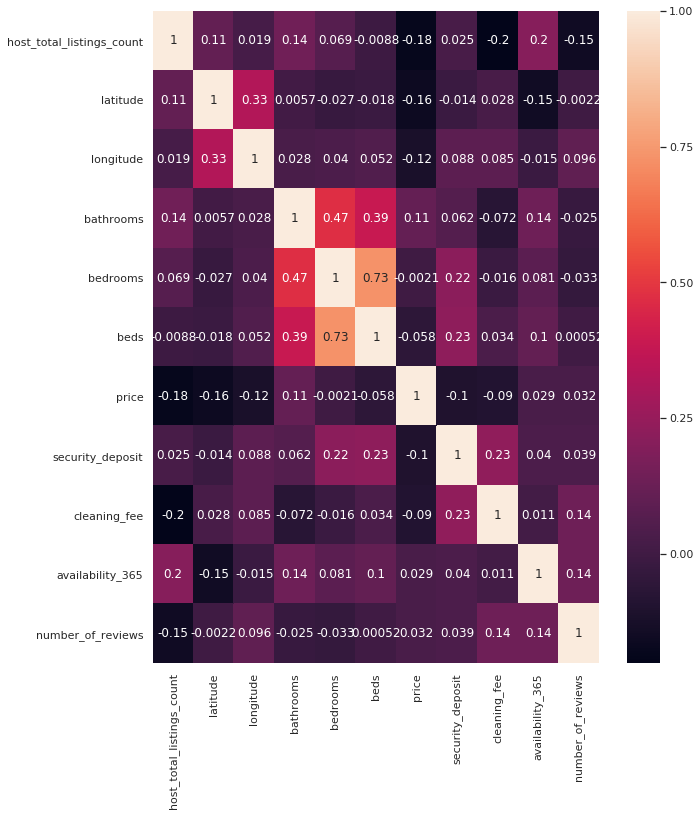

In [156]:
sns.heatmap(listings_train.corr(), annot=True)

It appears that price is associated with host_total_listings_count with a potential negative relationship, it is uncorrelated with latitute and longitude, it is not associated strongly with bathrooms bedrooms, and beds. There is not a strong relationship with number of reviews, availablility_365, cleaning_fee, or security_deposit, with maybe a slight negative relationship with security deposit. The strongest relationship in magnitude is price with host_total_listings_count, but even that has a correlation of only -0.18, near 0.

Predictors doesn’t seem to have linear relationship with response variable (price).

Maybe bathrooms, bedrooms, beds, and security deposit are good candidates to investigate for non-linear relationships.

Predictors doesn’t seem to have a strong linear relationship with response variable (price).

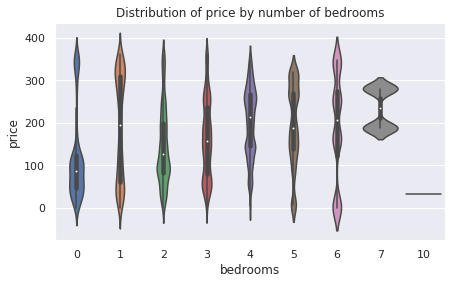

In [157]:
# Other plots that are helpful to determine linearity / nonlinearity, drawn from student submission
# This an example plot you could use for other predictors
sns.set(rc={'figure.figsize':(7,4)})
sns.violinplot(listings_train['bedrooms'], listings_train['price'], bw=.2).set_title('Distribution of price by number of bedrooms');

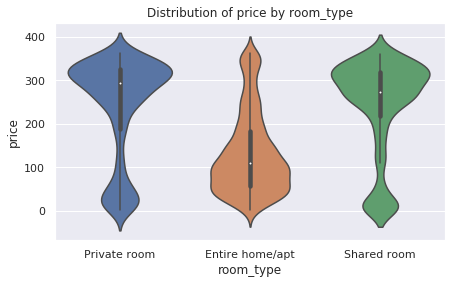

In [158]:
# Other plots that are helpful to determine linearity / nonlinearity, drawn from student submission
sns.violinplot(listings_train['room_type'], listings_train['price'], bw=.2).set_title('Distribution of price by room_type');

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [29]:
numeric_columns = ['host_total_listings_count', 'latitude', 'longitude', 
                   'bathrooms', 'bedrooms', 'beds', 'security_deposit',
                   'cleaning_fee', 'availability_365', 'number_of_reviews']
categorical_columns = ['room_type']

linear_formula = 'price ~ '+ " + ".join(["{}".format(x) for x in numeric_columns]) + " + " + " + ".join(["C({})".format(x) for x in categorical_columns])
listing_linear = sm.ols(linear_formula, data=listings_train).fit()

In [30]:
listing_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     120.7
Date:                Wed, 05 Feb 2020   Prob (F-statistic):          1.45e-260
Time:                        17:41:50   Log-Likelihood:                -26307.
No. Observations:                4370   AIC:                         5.264e+04
Df Residuals:                    4357   BIC:                         5.272e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -5377.6154   5118.394     -1.051      0.293   -1.54e+04    4657.041
C(room_type)[T.Private room]   106.3116      3.797     27.996      0.000      98.867     113.756
C(room_type)[T.Shared room]    110.2951     14.251      7.739      0.000      82.356     138.234
host_total_listings_count       -0.0539      0.008     -7.002      0.000      -0.069      -0.039
latitude                       -69.0003     66.557     -1.037      0.300    -199.486      61.485
longitude                     -118.0637     49.533     -2.384      0.017    -215.173     -20.955
bathrooms                       25.1626      3.479      7.232      0.000      18.342      31.983
bedrooms                        10.6730      2.698      3.956      0.000       5.384      15.962
beds                             0.2076      1.877      0.111      0.912      -3.473       3.888
security_deposit                -0.0608      0.098     -0.622      0.534      -0.252       0.131
cleaning_fee                    -0.1466      0.042     -3.506      0.000      -0.229      -0.065
availability_365                 0.0316      0.012      2.725      0.006       0.009       0.054
number_of_reviews               -0.0027      0.036     -0.076      0.939      -0.073       0.068
==============================================================================
Omnibus:                        8.454   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.748
Skew:                          -0.081   Prob(JB):                       0.0126
Kurtosis:                       3.148   Cond. No.                     9.18e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
poly_formula = 'price ~ '+ " + ".join(["{} + np.power({},2) + np.power({},3)".format(x,x,x) for x in numeric_columns]) + " + " + " + ".join(["C({})".format(x) for x in categorical_columns])

listing_poly = sm.ols(poly_formula, data=listings_train).fit()

In [32]:
listing_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     53.67
Date:                Wed, 05 Feb 2020   Prob (F-statistic):          3.12e-270
Time:                        17:41:50   Log-Likelihood:                -26245.
No. Observations:                4370   AIC:                         5.255e+04
Df Residuals:                    4339   BIC:                         5.275e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               3735.8991   2703.857      1.382      0.167   -1565.041    9036.839
C(room_type)[T.Private room]             107.4038      4.149     25.889      0.000      99.270     115.537
C(room_type)[T.Shared room]              114.1056     14.233      8.017      0.000      86.202     142.009
host_total_listings_count                  0.4036      0.081      4.959      0.000       0.244       0.563
np.power(host_total_listings_count, 2)    -0.0010      0.000     -4.219      0.000      -0.002      -0.001
np.power(host_total_listings_count, 3)  5.488e-07    1.7e-07      3.232      0.001    2.16e-07    8.82e-07
latitude                                 5.26e+04   3.81e+04      1.380      0.168   -2.21e+04    1.27e+05
np.power(latitude, 2)                  -4618.1495   2146.596     -2.151      0.032   -8826.574    -409.725
np.power(latitude, 3)                     62.9292     30.328      2.075      0.038       3.470     122.388
longitude                               -8.85e+04    6.4e+04     -1.382      0.167   -2.14e+05    3.71e+04
np.power(longitude, 2)                 -1737.0447   2101.854     -0.826      0.409   -5857.753    2383.663
np.power(longitude, 3)                   -10.4614     15.727     -0.665      0.506     -41.295      20.372
bathrooms                                 -0.8275     33.365     -0.025      0.980     -66.241      64.586
np.power(bathrooms, 2)                    18.3841     15.083      1.219      0.223     -11.186      47.955
np.power(bathrooms, 3)                    -3.6975      1.967     -1.880      0.060      -7.553       0.158
bedrooms                                  12.2341      7.034      1.739      0.082      -1.557      26.025
np.power(bedrooms, 2)                      1.0616      2.919      0.364      0.716      -4.661       6.784
np.power(bedrooms, 3)                     -0.3050      0.288     -1.059      0.290      -0.870       0.260
beds                                      -8.7820      6.452     -1.361      0.174     -21.431       3.867
np.power(beds, 2)                          1.5116      1.367      1.106      0.269      -1.168       4.191
np.power(beds, 3)                         -0.0660      0.070     -0.942      0.346      -0.203       0.071
security_deposit                           0.8716      0.933      0.934      0.350      -0.957       2.701
np.power(security_deposit, 2)             -0.0744      0.048     -1.558      0.119      -0.168       0.019
np.power(security_deposit, 3)              0.0011      0.001      1.851      0.064   -6.77e-05       0.002
cleaning_fee                               1.2578      0.433      2.902      0.004       0.408       2.108
np.power(cleaning_fee, 2)                 -0.0312      0.010     -3.090      0.002     

In [33]:
print("Linear Model Test R^2 {:0.3f} (Train was {:0.3f})".format(r2_score(listings_test['price'], listing_linear.predict(listings_test)),
                                           r2_score(listings_train['price'], listing_linear.predict(listings_train))
                                          ))

print("Polynomial Model Test R^2 {:0.3f} (Train was {:0.3f})".format(r2_score(listings_test['price'], listing_poly.predict(listings_test)),
                                           r2_score(listings_train['price'], listing_poly.predict(listings_train))
                                          ))

Linear Model Test R^2 0.185 (Train was 0.249)
Polynomial Model Test R^2 0.238 (Train was 0.271)


The polynomial model clearly outperforms the linear model here.

### Part 2b: Generalized Additive Model (GAM)

Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


Students should describe the potential advantage of additive regression model, the ability to find nonlinear relationships, etc. 

GAM lets it fit a smooth spline to each factor, helping to find nonlinear relationships between predictor and response. 


In [34]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

def get_gam_xy(df, categorical_columns=categorical_columns, numeric_columns=numeric_columns):
    '''
    Returns the GAM design matrix, X, and y from input df
    '''
    X = df.loc[:,categorical_columns + numeric_columns]

    for name in categorical_columns:
        le =  LabelEncoder().fit(df[name].values)
        X[name] = le.transform(X[name])
    y = df["price"]
    return X, y

X_train, y_train = get_gam_xy(listings_train)
X_test, y_test = get_gam_xy(listings_test)

# procedurally build the formula (typing it out is bug-prone, and a total pain...)
formula = f(0)
for i,name in enumerate(categorical_columns[1:]):
    formula += f(i)
for j,name in enumerate(numeric_columns):
    formula += s(j+len(categorical_columns))
print(formula)

listings_gam = LinearGAM(formula).fit(X_train, y_train)

f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10)


In [35]:
print("GAM Model Test R^2 {:0.3f} (Train was {:0.3f})".format(r2_score(y_test, listings_gam.predict(X_test)),
                                           r2_score(y_train, listings_gam.predict(X_train))
                                          ))

GAM Model Test R^2 0.245 (Train was 0.297)


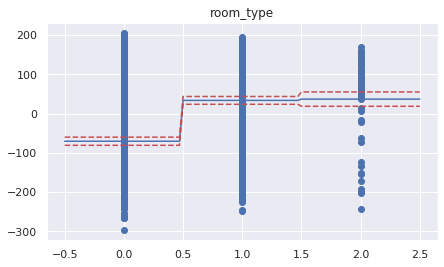

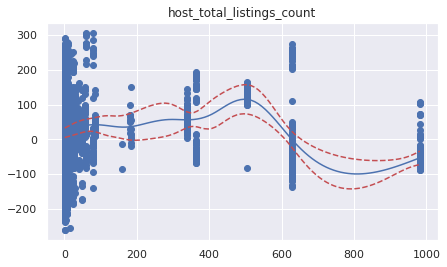

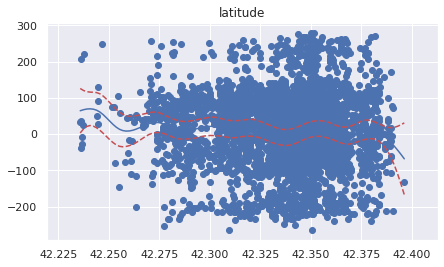

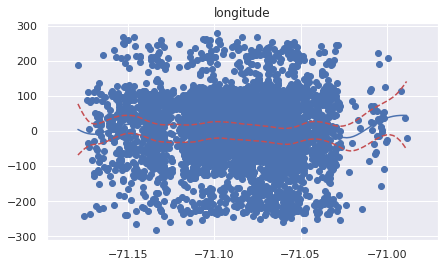

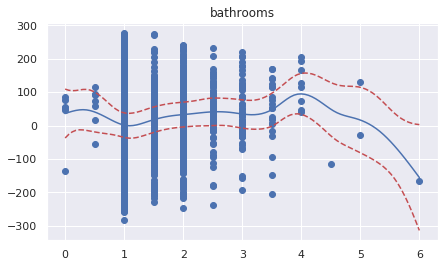

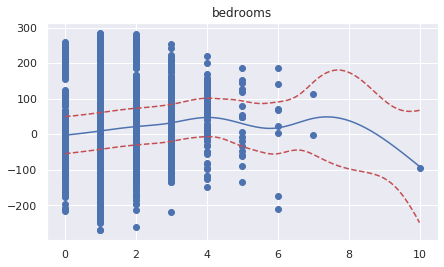

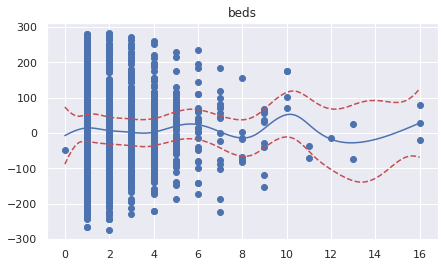

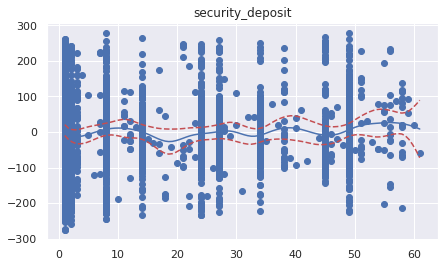

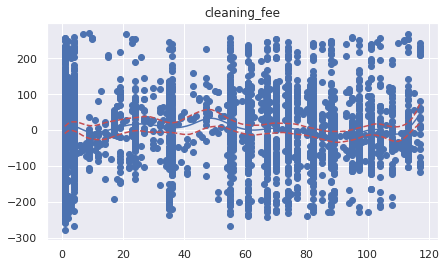

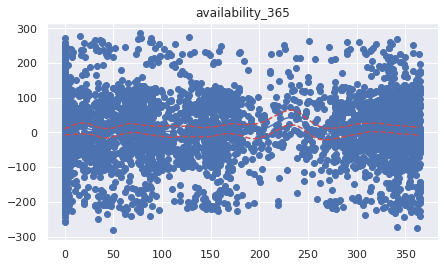

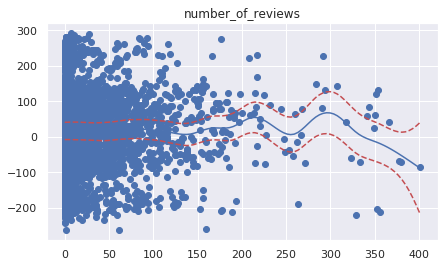

In [36]:
res = listings_gam.deviance_residuals(X_train,y_train)
for i, term in enumerate(listings_gam.terms):
    if term.isintercept:
        continue

    XX = listings_gam.generate_X_grid(term=i)
    pdep, confi = listings_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = listings_gam.partial_dependence(term=i, X=X_train, width=0.95)
    plt.figure()
    plt.scatter(X_train.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X_train.columns.values[term.feature])
    plt.show()

Insights: host_total_listings_count appears to have the strongest indication of a non-linear relationship with price. For many others, although there might be an indication of non-linearity, a linear fit would still fall within the confidence intervals displayed. A few influential points might impacting potential nonlinearity, for example with bedrooms. 

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

* **Listings** There isn't much of an effect for people with fewer than 500 listings.  After that, the more properties someone lists, the lower the price gets.
* **Bathrooms** Prices steadily increase from 1 to 4 bathrooms, then fall back down. But with much less certainty on the falling down after 4 bathrooms. The interval widens considerably.
* **Bedrooms/Beds** Surprisingly, neither variable shows a strong (above-noise) impact on price, except on listings with ridiculous numbers of each. Possibly, this is because listings with more beds in high-demand areas are more expensive, but listings with more beds are also more likely to exist in low-demand areas (suburbs), cancelling out the effects)
* **Security Deposit** This is a weak effect, but prices are slightly higher at the top end of security deposits.
* **Cleaning Fee** This is mostly flat up to 60, then higher cleaning fees start to lower the quoted rent (probably just listers trying to trick people who compare based on the headline price and ignore excessive cleaning fees)
* **Availability_365** Small effect, probably not worth including in the model
* **Number of Reviews** Roughly now effect. Potential decline after 230.

---
Based on problem 1, it appears that visiting on a weekday and braving one of the colder winter months is the best way to save money.

Based on problem 2, the most important factors (as modeled) appear to be room type and little else, so the frugal traveller should additionally try to rent the full home. Perhaps choosing one where the host has many total listings would be a good strategy as well.